# PHASE 2 FINAL PROJECT

## 1. INTRODUCTION
**Megamax Real Estate Agency** a well known Real Estate Agency in New York has decided to start a new division which connects home sellors to potential buyers for a small fee. It wants to find out how home rennovations may affect the **saleprices** of the homes of potential sellors. This is to advise potential sellors appropiately, to increase market appeal of their houses.

**Megamax Real Estate Agency** has decided to hire you as a Data Scientist to predict how rennovations may affect the price of a house. After analysis, you are to present your findings and insights to the head of the new division, who will use both to see how rennovations will affect the saleprice of the home of a potential sellor.

## 2. OBJECTIVES
The objectives of the project are:
- To determine how rennovations affect the saleprice of the home of a potential sellor.
- To present findings and model to head of division so that the head may use the insights generated to advise potential sellors(clients).

## 3. BUSINESS UNDERSTANDING
#### 3.1 PROBLEM STATEMENT
To determine the effect of home rennovations on the saleprice of a home. This is to help Megamax Real Estate Agency in making informed decisions to potential sellors of homes who are their clients.

#### 3.2 MEASUREMENT OF SUCCESS
The goal is to determine the effect of home rennovations on the saleprice of homes. The measure of success will therefore be after analysis has been done and insights generated,findings should be presented to the head of the new divisions who will use both to advise new sellors appropiately.

## 4. DATA UNDERSTANDING
For the problem at hand the data used to see the effect of rennovations on the price of houses was the King County House Sales dataset. This dataset was sourced from Kaggle and is relevant to the problem at hand as it contains data about relevant features of houses together with the price of such homes. These features are in the form of columns in a dataframe and they include:

- **Price** : This is the target(dependent) variable and is what we want to see the effect of rennovations on.

- **Bedrooms**: This is the number of bedrooms a house has and is one of the rennovations that may be performed to see the effect of SalePrice such that one may add or remove bedrooms to see the effect on SalePrice.

- **Floors**: This is the number of floors a house has and is relevant to the problem as a potential sellor may want to know the effect of adding or removing floors may have on the selling price of his/her home.

- **Condition**: This is the overall condition which has unique values as follows ['Average', 'Very Good', 'Good', 'Poor', 'Fair']. It is relevant to our problem as the client may want to know whether rennovation of the house to make it look new will increase or decrease the selling price of the house.

- **sqft_above**: This is the overall square footage of the house minus the basement. It is relevant as this factor shows whether the size of the house minus the basement determines its selling price. A client with enough land may even decide to increase its size to see if it will increase its asking price.

- **waterfront**: This is the prescence of a waterfront in front of the house. A client may want to know whether adding a waterfront will decrease or increase the selling price of his/her home.

- **grade**: This is the type and quality of the material used in construction of houses. It also includes the finishing and the design quality of the house and the interiors. It is relevant to the problem as a client may want to know whether using high quality materials in the rennovation of his/ her house will lead to increase or decrease in the price of the house.

## 5. DATA PREPARATION

Before data is used for analysis one must ensure the data is clean. This is by:

- **Removing outliers**: Identification and removal of data points that deviate significantly from the overall distribution, as they can adversely impact analysis results.

- **Handling missing values**: Thoroughly checking for missing values and employing appropriate strategies to handle them, such as imputation techniques or assessing the suitability of the missing data for analysis.

- **Identifying and resolving duplicates**: Identifying and removing duplicate records to ensure data integrity and avoid bias in analysis outcomes.

- **Assessing columns with excessive missing values**: Evaluating columns with a substantial number of missing values and determining their relevance to the analysis. Dropping columns that are not essential or exploring alternative strategies for handling missing data.


- **Correcting data types**: Verifying and correcting the data types of variables to align them with their intended representation (e.g., converting numerical data from strings to numeric types).



**This was done by first loading important libraries that will be used for data preparation and for this project.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

**The data is then loaded to see how the dataset looks like**

In [2]:
house_data = pd.read_csv('data/kc_house_data.csv')
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


**Checking the general info of the dataframe such as the datatypes of each column and whether or not each column has missing values.**

In [3]:
# Looking at general info of the dataframe missing values and the dtypes of each column in the dataframe
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

**Several columns have missing values so now the task is to check the percentage of missing values for each column in the dataframe so as to know what to handle these missing values**.

In [4]:
# Function for checking percentage of missing values in every column in the dataframe and putting values in a dictionary then a dataframe
# Also creates a new column for the datatype of the columns.
def missing_percentage(df):

    # Dictionary for putting percentage of missing values
    missing_values_percentage = {}
    
    # Loop for calculating percentage of missing values and putting values in dictionary
    for column in df.columns:
        missing_values_percentage[column] = df[column].isnull().sum() / len(df[column]) * 100

    # Creating dataframe of the dictionary
    missing_df = pd.Series(missing_values_percentage)
    missing_df = pd.DataFrame(missing_df, columns=['Percentage Missing'])


    # Creating a new column for the dtype of the column with missing values.
    missing_df['dtype'] = [df[column].dtypes for column in missing_df.index]

    return missing_df





**Creating a copy of the house data dataframe to see if the function to check the percentage of missing values in the dataframe works before proceeding to apply it to the actual dataset**

In [5]:
# Copy of data to test our new function.
X_test = house_data.copy()

# Testing
missing_percentage(X_test)

,Percentage Missing,dtype
id,0.000000,int64
date,0.000000,object
price,0.000000,float64
bedrooms,0.000000,int64
bathrooms,0.000000,float64
sqft_living,0.000000,int64
sqft_lot,0.000000,int64
floors,0.000000,float64
waterfront,11.001528,object
view,0.291707,object


**Now applying the same function to the actual dataset to see the percentage of missing values for each column in the dataframe**.

In [6]:
missing_percentage(house_data)

,Percentage Missing,dtype
id,0.000000,int64
date,0.000000,object
price,0.000000,float64
bedrooms,0.000000,int64
bathrooms,0.000000,float64
sqft_living,0.000000,int64
sqft_lot,0.000000,int64
floors,0.000000,float64
waterfront,11.001528,object
view,0.291707,object


 It appears the **view**, **waterfront** and **yr_renovated** columns have missing data we shall deal with each individually

In [7]:
# For the view column only 0.291707% of its data is missing so we can just drop the rows with missing values.
house_data.dropna(subset='view', inplace=True)

# Checking to see if it worked
house_data.isnull().sum()


id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2370
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3830
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

**The view column no longer has missing values.**

For the waterfront column first we want to see the percentage of the number of 'NO' values to that of 'YES' values to know how to deal with missing values.

In [8]:
waterfront_no = dict(house_data['waterfront'].value_counts())

df_copy = house_data.copy()

replacement_dict = {'YES': 1, 'NO': 0}
df_copy['waterfront'].replace(replacement_dict, inplace=True)

no_of_no = df_copy['waterfront'].value_counts()[0]
no_of_yes = df_copy['waterfront'].value_counts()[1]

total = no_of_no + no_of_yes

print('The percentage of no values is', (no_of_no/total) * 100, 'while the percentage of yes values is', (no_of_yes/total) * 100)

The percentage of no values is 99.24337299102484 while the percentage of yes values is 0.7566270089751618


**Since the majoirty of values are 'NO' filling missing values with yes or no should not make a significant difference on the outcome we will therefore choose to fill missing values with the majority number which is 'NO'**

In [9]:
house_data['waterfront'].fillna(house_data['waterfront'].mode()[0], inplace=True)

# Checking to see if it worked
house_data.isnull().sum()  # It worked now only the yr_renovated column.

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3830
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Now we deal with the yr_renovated column which has **3830** missing values. Which is **17.789508%** of its data missing.

First step so as to know how to deal with the missing valuesis to draw a scatter plot of Price against yr_renovated. This will help us see if there's a correlation between year renovated and the price so that we can see the effect of missing values on that correlation.

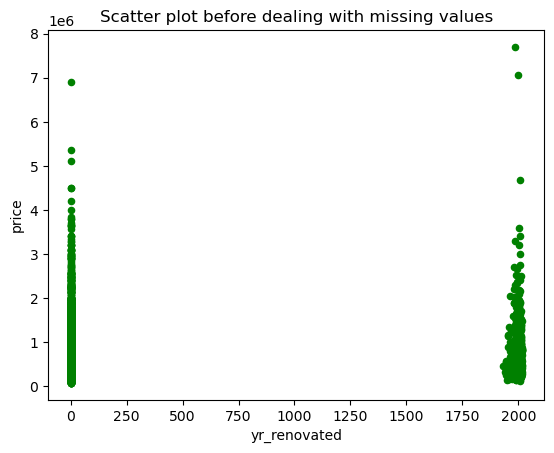

In [10]:
house_data.plot.scatter(x='yr_renovated', y='price', c='green');
plt.title('Scatter plot before dealing with missing values');

**There seems to be no correlation between the yr_renovated and the price of the house let us see what happens if we fill it with the mean.**

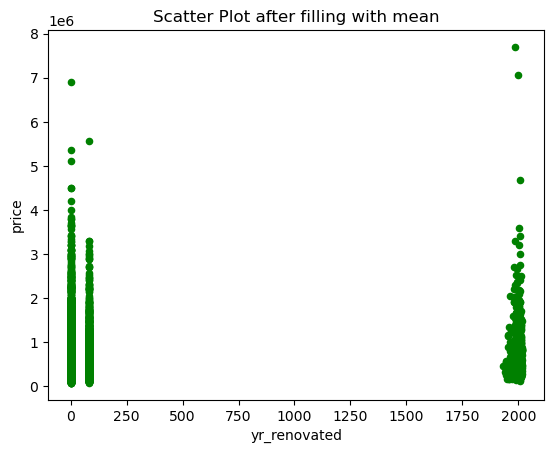

In [11]:
# Lets create a copy before doing it on the actual dataframe.
test_data = house_data.copy()

# We now filling missing values of this copy of the dataframe with the mean to see what happens to the correlation between the two.
test_data['yr_renovated'].fillna(test_data['yr_renovated'].mean(), inplace=True)

# Seeing if the original dataframe was affected.
house_data.isnull().sum()  # No effect.

# Plotting scatter plot with test data.
test_data.plot.scatter(x='yr_renovated', y='price', c='green')
plt.title('Scatter Plot after filling with mean');


**Filling with the missing values with mean seems to have no effect on the correlation between the yr_renovated column and the price column let us see what happens if we fill with the mode.**

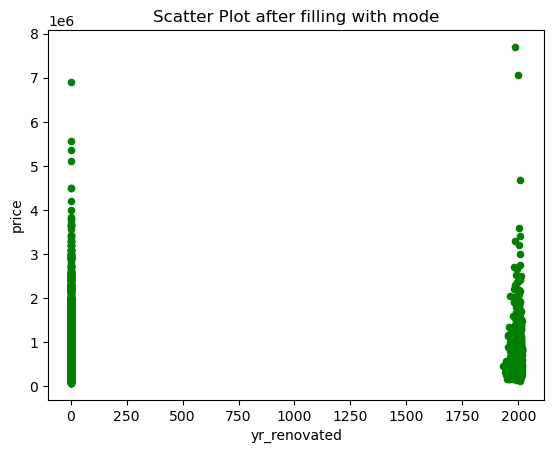

In [12]:
# Creating copy
new_test_data = house_data.copy()

# Filling copy with mode of column
new_test_data['yr_renovated'].fillna(new_test_data['yr_renovated'].mode()[0], inplace=True)

# Checking to see if missing values of copy have been filled
new_test_data.isnull().sum()

# Plotting scatter plot
new_test_data.plot.scatter(x='yr_renovated', y='price', c='green')
plt.title('Scatter Plot after filling with mode');

**The reason why we chose to see the effects of filling the missing values with mean or mode is we wanted to see if there's a correlation between the independent variable and the dependent variable and if filling missing values with mean or mode would have an effect on this correlation. There however seems to be no correlation between the two, so even if we fill with the mean, which we'll do it should have no effect on the relationship between the independent and dependent variable.**

In [13]:
# Filling missing values of 'yr_renovated' column with the mean of the values.
house_data['yr_renovated'].fillna(house_data['yr_renovated'].mean(), inplace=True)

# Seeing if it worked
house_data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### The missing values have been dealt with we now want to check for wrong datatypes as part of the data preparation process.

#### This we will do by creating a function that checks for wrong datatypes in a dataframe.

In [14]:
# Function for checking for wrong datatypes in each column in the dataframe.

def wrong_data(df):
    # Dictionary for mapping
    value_types = {
        'int64': int,
        'object': str,
        'float64': float
    }
    # Dictionary for mapping columns with wrong datatypes
    wrong_data_types = {}

    # Loop which checks for every column in the dataframe if it has wrong datatypes.
    for column in df.columns:
        wrong_data_types[column] = [x for x in df[column] if type(x) != value_types[str(df[column].dtypes)]]

    # Final results
    return wrong_data_types



#### After creating our function we test it on our dataframe **house_data**

In [15]:
# Testing our function on a copy of the data
wrong_data(house_data)



{'id': [],
 'date': [],
 'price': [],
 'bedrooms': [],
 'bathrooms': [],
 'sqft_living': [],
 'sqft_lot': [],
 'floors': [],
 'waterfront': [],
 'view': [],
 'condition': [],
 'grade': [],
 'sqft_above': [],
 'sqft_basement': [],
 'yr_built': [],
 'yr_renovated': [],
 'zipcode': [],
 'lat': [],
 'long': [],
 'sqft_living15': [],
 'sqft_lot15': []}

### There appears to be no wrong datatypes in our house dataset the next is to deal with outliers in the data we shall do this by creating a function to do this.

First we want to see how the dependent variable looks before outliers are removed.

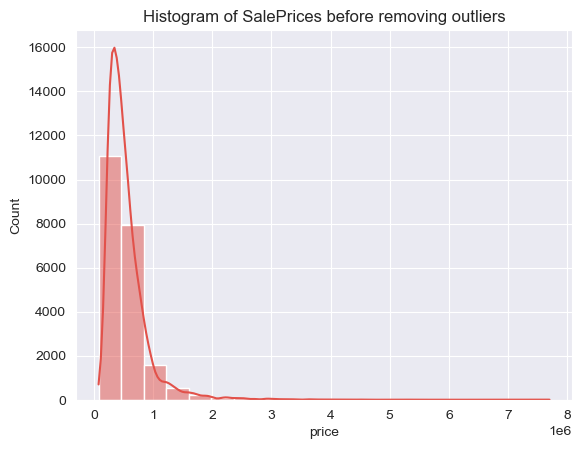

In [16]:
# Histogram of price before removing outliers
# setting a style for plots
sns.set_palette("Spectral")
sns.set_style("darkgrid")

# Plotting
sns.histplot(house_data['price'], kde=True, bins=20)
plt.title('Histogram of SalePrices before removing outliers');

**Before outliers are removed the graph appears to be left skewed with majority of the data on the left side.**

Since outliers can only be checked and removed on numeric variables we will seperate the numeric and categorical variables to deal with the numeric variables seperately.

In [17]:
# Creating a copy of the dataframe to remove outliers to see if it works before applying to our real data.
X_test = house_data.copy()

# Isolating numeric variables
numeric_variables = X_test.select_dtypes(include=np.number).columns.to_list()

numeric_variables

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [18]:
# Function for checking outliers in a dataframe removing them and creating a new dataframe without outliers
def outliers(df):

    # Dictionary for placing no. of outliers and the column name.
    outliers_dict = {}
    standardized_dict = {}

    # For loop for checking outliers in every column in the dataframe.
    for column in df.columns:
        # Lower quantile
        Q1 = df[column].quantile(0.25)

        # Upper Quantile
        Q3 = df[column].quantile(0.75)

        # Finding IQR
        IQR = Q3 - Q1

        # Defining lower and upper bound
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        # Finding outliers
        outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_dict[column] = 'The number of outliers is', len(outliers)

        # Data without outliers
        standardized_numvotes = df[column][(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        
        # Putting standardized values in a dict
        standardized_dict[column] = standardized_numvotes

    
    standardized_df = pd.DataFrame(standardized_dict)  

    # Results
    return standardized_df

After creating our function for removing outliers we can now test it on a copy of the dataframe **X_test** to see if it works

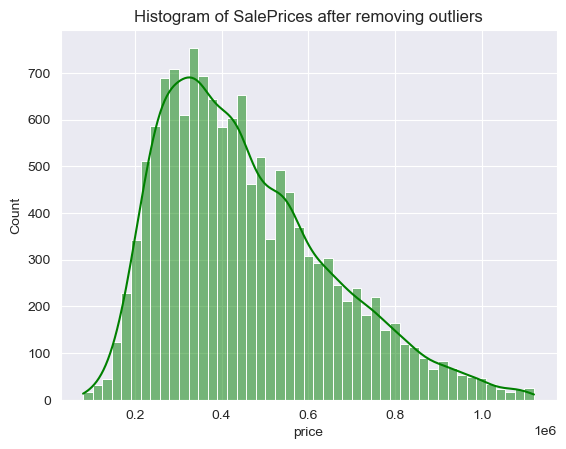

In [19]:
new_df = outliers(X_test[numeric_variables])

# Since all values which are not within the range will now be Nan values 
new_df.dropna(inplace=True)

# Histogram of price after removing outliers.
sns.histplot(new_df['price'], kde=True, color='green', bins='auto')
plt.title('Histogram of SalePrices after removing outliers');

**After removing outliers it appears the data for the SalePrice appears to be almost following a bell curve**.

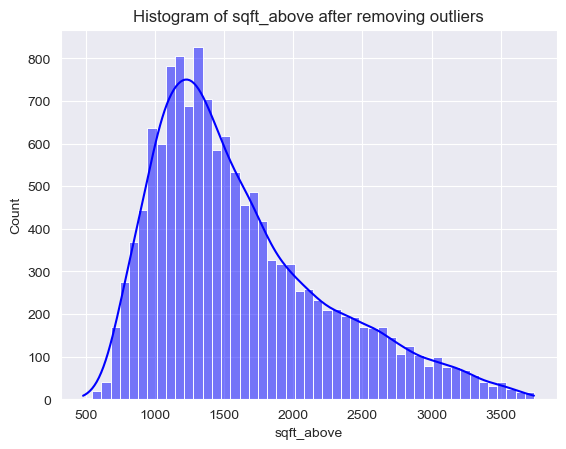

In [20]:
sns.histplot(new_df['sqft_above'], kde=True, color='blue')
plt.title('Histogram of sqft_above after removing outliers');

### Now the final task in data cleaning is to check for duplicates in our dataframe.

In [21]:
# Checking for duplicates
house_data[house_data.duplicated()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


### There are no duplicates in the dataset.

**Now that there are no longer missing values, outliers, wrong datatypes and duplicates in the dataset we can move on to Exploratory Data Analysis.**

## 6. EXPLORATORY DATA ANALYSIS
### 6.1 Univariate Analysis.

Here in univariate analysis we want to investigate individual variables without looking at the relationship between variables. It involves examining and understanding the distribution, central tendency, dispersion, and other characteristics of a single variable.

First we check if our new dataframe after removing outliers has any missing values

In [22]:
# Checking if the new_df has null values
new_df.isnull().sum()

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
sqft_above       0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

**No missing values**

We now want to see the correlations of each of the numeric independent variables to the dependent variable **price**.

In [23]:
# Finding correlation of each independent variable to the target variable and putting values in a dictionary.
corr_dict = {}

for column in new_df.columns:
    corr_dict[column] = np.corrcoef(new_df[column], new_df['price'])[0][1]

pd.Series(corr_dict).sort_values(ascending=False)

c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


price            1.000000
sqft_living      0.565806
sqft_living15    0.510148
lat              0.465000
sqft_above       0.448941
bathrooms        0.377830
bedrooms         0.260439
floors           0.232199
long             0.049897
id               0.038091
yr_built         0.012729
zipcode         -0.005081
sqft_lot        -0.024455
sqft_lot15      -0.030929
yr_renovated          NaN
dtype: float64

**From this analysis one can see that sqft_living has the highest correlation with price hence the bigger the house the higher the selling price is more likely to be.**

Our next step is to convert the remaining categorical variables to numeric so that we can have a complete dataset with all values in number format

In [24]:
# Isolating categorical variables by using sets to remove all columns which are not the numeric variables
categorical_variables = list(set(house_data.columns) - set(house_data[numeric_variables]))

# Making df of categorical variables
categorical_df = house_data[categorical_variables]

# First step is converting sqft_basement to numeric and then placing it in the same dataframe with other numeric variables.
categorical_df['sqft_basement'][categorical_df['sqft_basement'] == '?']

# First attempt there were several values with ? so first one has to replace them with 0.
replacement_dict = {'?' : 0}

categorical_df['sqft_basement'] = categorical_df['sqft_basement'].replace(replacement_dict)

categorical_df['sqft_basement'][categorical_df['sqft_basement'] == '600']

new_df['sqft_basement'] = categorical_df['sqft_basement'].astype(float)

corr_dict = {}

for column in new_df.columns:
    corr_dict[column] = np.corrcoef(new_df[column], new_df['price'])[0][1]

pd.Series(corr_dict).sort_values(ascending=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_11452\2604611372.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_df['sqft_basement'] = categorical_df['sqft_basement'].replace(replacement_dict)
c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


price            1.000000
sqft_living      0.565806
sqft_living15    0.510148
lat              0.465000
sqft_above       0.448941
bathrooms        0.377830
bedrooms         0.260439
sqft_basement    0.236748
floors           0.232199
long             0.049897
id               0.038091
yr_built         0.012729
zipcode         -0.005081
sqft_lot        -0.024455
sqft_lot15      -0.030929
yr_renovated          NaN
dtype: float64

In [25]:
categorical_df

,grade,view,waterfront,sqft_basement,date,condition
0,7 Average,NONE,NO,0.0,10/13/2014,Average
1,7 Average,NONE,NO,400.0,12/9/2014,Average
2,6 Low Average,NONE,NO,0.0,2/25/2015,Average
3,7 Average,NONE,NO,910.0,12/9/2014,Very Good
4,8 Good,NONE,NO,0.0,2/18/2015,Average
...,...,...,...,...,...,...
21592,8 Good,NONE,NO,0.0,5/21/2014,Average
21593,8 Good,NONE,NO,0.0,2/23/2015,Average
21594,7 Average,NONE,NO,0.0,6/23/2014,Average
21595,8 Good,NONE,NO,0.0,1/16/2015,Average


**Since every categorical variable is unique and they are not many we shall deal with each uniquely starting with the condition variable**

In [26]:
# Seeing the unique values to know what to replace with numbers
categorical_df['condition'].unique()

# Dictionary for replacing
condition_dict = {'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}

# Replacing condition variable with values in the dictionary
categorical_df['condition'] = categorical_df['condition'].replace(condition_dict)

# Seeing results
categorical_df

C:\Users\USER\AppData\Local\Temp\ipykernel_11452\558231530.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_df['condition'] = categorical_df['condition'].replace(condition_dict)


,grade,view,waterfront,sqft_basement,date,condition
0,7 Average,NONE,NO,0.0,10/13/2014,3
1,7 Average,NONE,NO,400.0,12/9/2014,3
2,6 Low Average,NONE,NO,0.0,2/25/2015,3
3,7 Average,NONE,NO,910.0,12/9/2014,5
4,8 Good,NONE,NO,0.0,2/18/2015,3
...,...,...,...,...,...,...
21592,8 Good,NONE,NO,0.0,5/21/2014,3
21593,8 Good,NONE,NO,0.0,2/23/2015,3
21594,7 Average,NONE,NO,0.0,6/23/2014,3
21595,8 Good,NONE,NO,0.0,1/16/2015,3


Now dealing with the **waterfront** column.

In [27]:
# Seeing unique values
categorical_df['waterfront'].unique()

# Replacement dictionary
waterfront_dict = {'NO': 0, 'YES': 1}

# Replacing
categorical_df['waterfront'] = categorical_df['waterfront'].replace(waterfront_dict)

# Seeing results
categorical_df

C:\Users\USER\AppData\Local\Temp\ipykernel_11452\527623146.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_df['waterfront'] = categorical_df['waterfront'].replace(waterfront_dict)


,grade,view,waterfront,sqft_basement,date,condition
0,7 Average,NONE,0,0.0,10/13/2014,3
1,7 Average,NONE,0,400.0,12/9/2014,3
2,6 Low Average,NONE,0,0.0,2/25/2015,3
3,7 Average,NONE,0,910.0,12/9/2014,5
4,8 Good,NONE,0,0.0,2/18/2015,3
...,...,...,...,...,...,...
21592,8 Good,NONE,0,0.0,5/21/2014,3
21593,8 Good,NONE,0,0.0,2/23/2015,3
21594,7 Average,NONE,0,0.0,6/23/2014,3
21595,8 Good,NONE,0,0.0,1/16/2015,3


Now the **view** column

In [28]:
categorical_df['view'].unique()

view_dict = {'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}

categorical_df['view'] = categorical_df['view'].replace(view_dict)

categorical_df

C:\Users\USER\AppData\Local\Temp\ipykernel_11452\3852148749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_df['view'] = categorical_df['view'].replace(view_dict)


,grade,view,waterfront,sqft_basement,date,condition
0,7 Average,0,0,0.0,10/13/2014,3
1,7 Average,0,0,400.0,12/9/2014,3
2,6 Low Average,0,0,0.0,2/25/2015,3
3,7 Average,0,0,910.0,12/9/2014,5
4,8 Good,0,0,0.0,2/18/2015,3
...,...,...,...,...,...,...
21592,8 Good,0,0,0.0,5/21/2014,3
21593,8 Good,0,0,0.0,2/23/2015,3
21594,7 Average,0,0,0.0,6/23/2014,3
21595,8 Good,0,0,0.0,1/16/2015,3


And finally the grade column as we will not replace the date column to numeric values and the sqft_basement has already been converted to numeric


In [29]:
# Seeing unique values
categorical_df.grade.unique()

# Dictionary used for replacing
grade_dict = {'3 Poor': 1, '4 Low': 2, '5 Fair': 3, '6 Low Average': 4, '7 Average': 5, '8 Good': 6, '9 Better': 7, '10 Very Good': 8, '11 Excellent': 9, '12 Luxury': 10, '13 Mansion': 11}

# Replacing with values in the dictionary
categorical_df['grade'] = categorical_df['grade'].replace(grade_dict)

# Seeing results
categorical_df

C:\Users\USER\AppData\Local\Temp\ipykernel_11452\3838150199.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_df['grade'] = categorical_df['grade'].replace(grade_dict)


,grade,view,waterfront,sqft_basement,date,condition
0,5,0,0,0.0,10/13/2014,3
1,5,0,0,400.0,12/9/2014,3
2,4,0,0,0.0,2/25/2015,3
3,5,0,0,910.0,12/9/2014,5
4,6,0,0,0.0,2/18/2015,3
...,...,...,...,...,...,...
21592,6,0,0,0.0,5/21/2014,3
21593,6,0,0,0.0,2/23/2015,3
21594,5,0,0,0.0,6/23/2014,3
21595,6,0,0,0.0,1/16/2015,3


**Now that all categorical variables have been converted to numeric we will drop the sqft_basement as we had changed it to numeric earlier and then proceed to combine the dataframes.**

In [30]:
# Dropping sqft_basement column
categorical_df.drop('sqft_basement', axis=1, inplace=True)

# Combining dataframe
combined_df = new_df.join(categorical_df)

# Checking if any new columns have been added as we did not want to add columns but instead replace data inside categorical columns with values.
assert len(combined_df.columns) == len(house_data.columns)  # True

C:\Users\USER\AppData\Local\Temp\ipykernel_11452\732555073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_df.drop('sqft_basement', axis=1, inplace=True)


Now that we have our combined dataframe in which the outliers have been removed and the categorical variables converted to numeric we can proceed with our analysis. Note that from now on we shall use **combined_df** from now on for analysis and model building

In [31]:
# Seeing our new combined_df
combined_df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,...,lat,long,sqft_living15,sqft_lot15,sqft_basement,grade,view,waterfront,date,condition
0,7129300520,221900.0,3.0,1.00,1180.0,5650.0,1.0,1180.0,1955,0.0,...,47.5112,-122.257,1340.0,5650.0,0.0,5,0,0,10/13/2014,3
3,2487200875,604000.0,4.0,3.00,1960.0,5000.0,1.0,1050.0,1965,0.0,...,47.5208,-122.393,1360.0,5000.0,910.0,5,0,0,12/9/2014,5
4,1954400510,510000.0,3.0,2.00,1680.0,8080.0,1.0,1680.0,1987,0.0,...,47.6168,-122.045,1800.0,7503.0,0.0,6,0,0,2/18/2015,3
6,1321400060,257500.0,3.0,2.25,1715.0,6819.0,2.0,1715.0,1995,0.0,...,47.3097,-122.327,2238.0,6819.0,0.0,5,0,0,6/27/2014,3
8,2414600126,229500.0,3.0,1.00,1780.0,7470.0,1.0,1050.0,1960,0.0,...,47.5123,-122.337,1780.0,8113.0,730.0,5,0,0,4/15/2015,3


Now we want to see the correlation with the dependent variable after changing categorical variable to numeric variables

In [32]:
corr_dict = {}
for column in combined_df.columns:
    if column == 'date':
        pass
    else:
        corr_dict[column] = np.corrcoef(combined_df[column], combined_df['price'])[0][1]

pd.Series(corr_dict).sort_values(ascending=False)

c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


price            1.000000
grade            0.580068
sqft_living      0.565806
sqft_living15    0.510148
lat              0.465000
sqft_above       0.448941
bathrooms        0.377830
bedrooms         0.260439
view             0.239203
sqft_basement    0.236748
floors           0.232199
condition        0.070718
long             0.049897
waterfront       0.043475
id               0.038091
yr_built         0.012729
zipcode         -0.005081
sqft_lot        -0.024455
sqft_lot15      -0.030929
yr_renovated          NaN
dtype: float64

**Now the grade has the highest correlation with price as opposed to before where the sqft_living was the one with the highest correlation with price**

We want to see how the independent variable correlates grade, which had the highest correlation, with the dependent variable using a scatterplot.

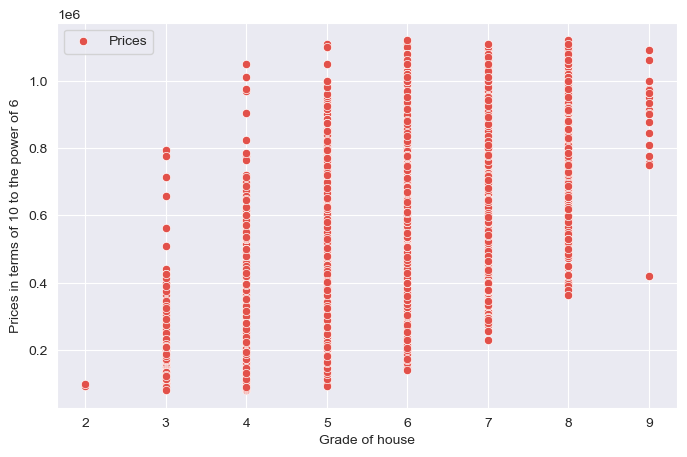

In [33]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=combined_df['grade'], y=combined_df['price'], label='Prices')
plt.ylabel('Prices in terms of 10 to the power of 6')
plt.xlabel('Grade of house')
plt.legend();

**The scatterplot above shows that the higher the grade of the house the higher the minimum saleprice is for the house.**

Now we want to get a general understanding of the statistics such as the mean, median, max and std of our new combined dataframe.

Since the **date** column is not relevant to our data we will drop the column.

In [34]:
combined_df.drop('date', axis=1, inplace=True)
combined_df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement,grade,view,waterfront,condition
0,7129300520,221900.0,3.0,1.00,1180.0,5650.0,1.0,1180.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0,0.0,5,0,0,3
3,2487200875,604000.0,4.0,3.00,1960.0,5000.0,1.0,1050.0,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0,910.0,5,0,0,5
4,1954400510,510000.0,3.0,2.00,1680.0,8080.0,1.0,1680.0,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0,0.0,6,0,0,3
6,1321400060,257500.0,3.0,2.25,1715.0,6819.0,2.0,1715.0,1995,0.0,98003,47.3097,-122.327,2238.0,6819.0,0.0,5,0,0,3
8,2414600126,229500.0,3.0,1.00,1780.0,7470.0,1.0,1050.0,1960,0.0,98146,47.5123,-122.337,1780.0,8113.0,730.0,5,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3.0,2.50,1530.0,1131.0,3.0,1530.0,2009,0.0,98103,47.6993,-122.346,1530.0,1509.0,0.0,6,0,0,3
21593,6600060120,400000.0,4.0,2.50,2310.0,5813.0,2.0,2310.0,2014,0.0,98146,47.5107,-122.362,1830.0,7200.0,0.0,6,0,0,3
21594,1523300141,402101.0,2.0,0.75,1020.0,1350.0,2.0,1020.0,2009,0.0,98144,47.5944,-122.299,1020.0,2007.0,0.0,5,0,0,3
21595,291310100,400000.0,3.0,2.50,1600.0,2388.0,2.0,1600.0,2004,0.0,98027,47.5345,-122.069,1410.0,1287.0,0.0,6,0,0,3


In [35]:
# We want to standardize our data to see how far the values fall from the mean.
test_standardized = combined_df.copy()
standardizer = lambda x: (x - x.mean()) / x.std()
test_standardized = test_standardized.apply(standardizer)

test_standardized.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement,grade,view,waterfront,condition
count,1.358700e+04,1.358700e+04,1.358700e+04,1.358700e+04,13587.000000,1.358700e+04,13587.000000,1.358700e+04,1.358700e+04,0.0,1.358700e+04,1.358700e+04,1.358700e+04,1.358700e+04,1.358700e+04,1.358700e+04,1.358700e+04,1.358700e+04,1.358700e+04,1.358700e+04
mean,-1.045916e-18,-1.882648e-17,2.599100e-16,-1.673465e-17,0.000000,4.183662e-17,0.000000,1.171425e-16,3.514276e-15,NaN,-1.884400e-14,-3.435623e-14,-7.558623e-14,1.966321e-16,-8.367324e-18,2.091831e-17,1.589792e-16,2.091831e-18,-9.936198e-18,2.677544e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.661412e+00,-1.927798e+00,-1.639185e+00,-1.907099e+00,-2.011403,-1.927454e+00,-0.868035,-1.809916e+00,-2.434786e+00,NaN,-1.475000e+00,-2.730469e+00,-2.186482e+00,-2.254367e+00,-2.082388e+00,-6.522911e-01,-3.706541e+00,-2.445062e-01,-2.846390e-02,-3.698818e+00
25%,-8.390646e-01,-7.778780e-01,-3.626556e-01,-7.641350e-01,-0.758308,-6.761468e-01,-0.868035,-7.443829e-01,-6.610611e-01,NaN,-8.836139e-01,-6.625755e-01,-8.434687e-01,-7.487223e-01,-6.839492e-01,-6.522911e-01,-4.875718e-01,-2.445062e-01,-2.846390e-02,-6.457933e-01
50%,-2.431908e-01,-1.911804e-01,-3.626556e-01,-2.159128e-03,-0.124211,2.131589e-03,-0.868035,-2.513750e-01,8.936107e-02,NaN,-1.259000e-01,7.281075e-02,-2.564028e-01,-1.795150e-01,7.014461e-02,-6.522911e-01,-4.875718e-01,-2.445062e-01,-2.846390e-02,-6.457933e-01
75%,9.618736e-01,5.977256e-01,9.138733e-01,7.598167e-01,0.645763,5.646349e-01,0.967892,5.437991e-01,9.080034e-01,NaN,6.872563e-01,8.723149e-01,6.282170e-01,6.100306e-01,5.966775e-01,6.301157e-01,5.854178e-01,-2.445062e-01,-2.846390e-02,8.807191e-01
max,1.798006e+00,3.394756e+00,2.190402e+00,2.283768e+00,3.484099,3.516608e+00,3.721783,3.374619e+00,1.487875e+00,NaN,2.184203e+00,1.568657e+00,3.298160e+00,3.327536e+00,3.476154e+00,4.582023e+00,3.804387e+00,6.857805e+00,3.512963e+01,2.407232e+00


**After standardizing our data here is a summary of the statistics of our dataframe as we can see the data is not highly dispersed as all the columns have values 1 std from the mean.**

We now want to see the dispersion of the data visually to how dispersed our standardized data from the mean.

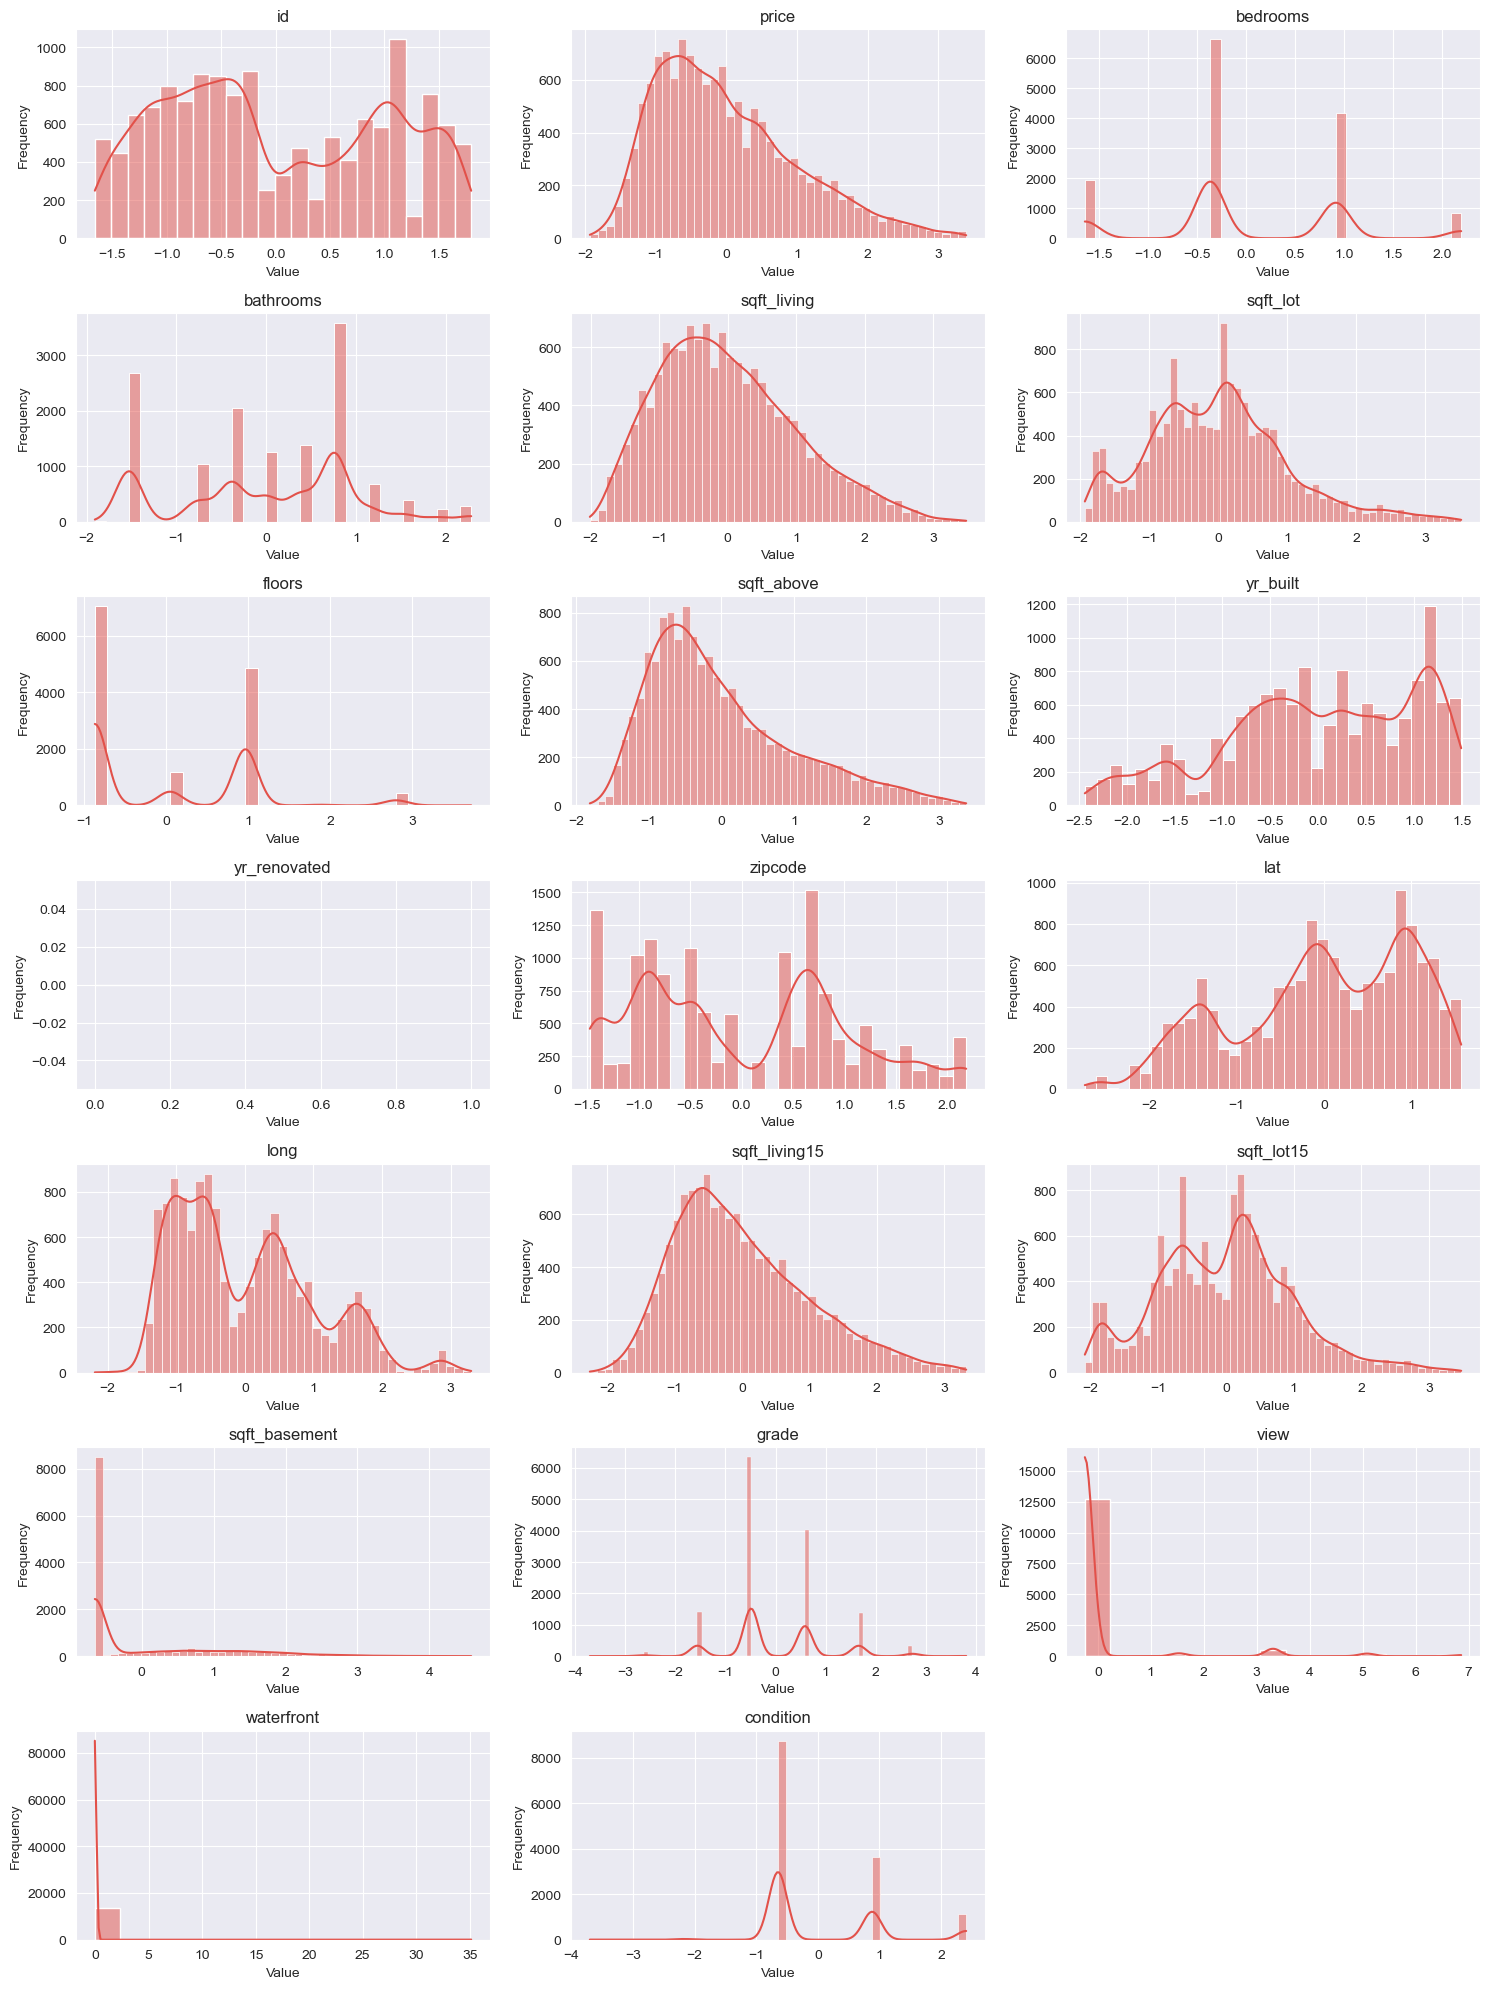

In [36]:
# Defining the number of rows and columns for subplots
num_rows = 7
num_cols = 3

# Creating the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

# Flattening the axes array for easy iteration
axes = axes.flatten()

# Iterating over each column
for i, column in enumerate(test_standardized.columns):
    # Select the current axis
    ax = axes[i]

    # Creatomg a histogram with KDE
    sns.histplot(test_standardized[column], kde=True, ax=ax)

    # Set the title and axis labels
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Removing any unused subplots
if i+1 < num_rows * num_cols:
    for j in range(i+1, num_rows * num_cols):
        fig.delaxes(axes[j])

# Adjusting the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


**As can be seen for all the columns in the dataframe most data falls within 3 standard deviations from the mean hence it is not highly dispersed.**

**It can also be seen for the continuous numeric variables such as 'sqft_living' and 'sqft_above' the data follows a normal distribution meaning outliers have been removed.**

Next we want to plot boxplots of our data to see the range of our data, here we will not use the standardized version of the dataframe.

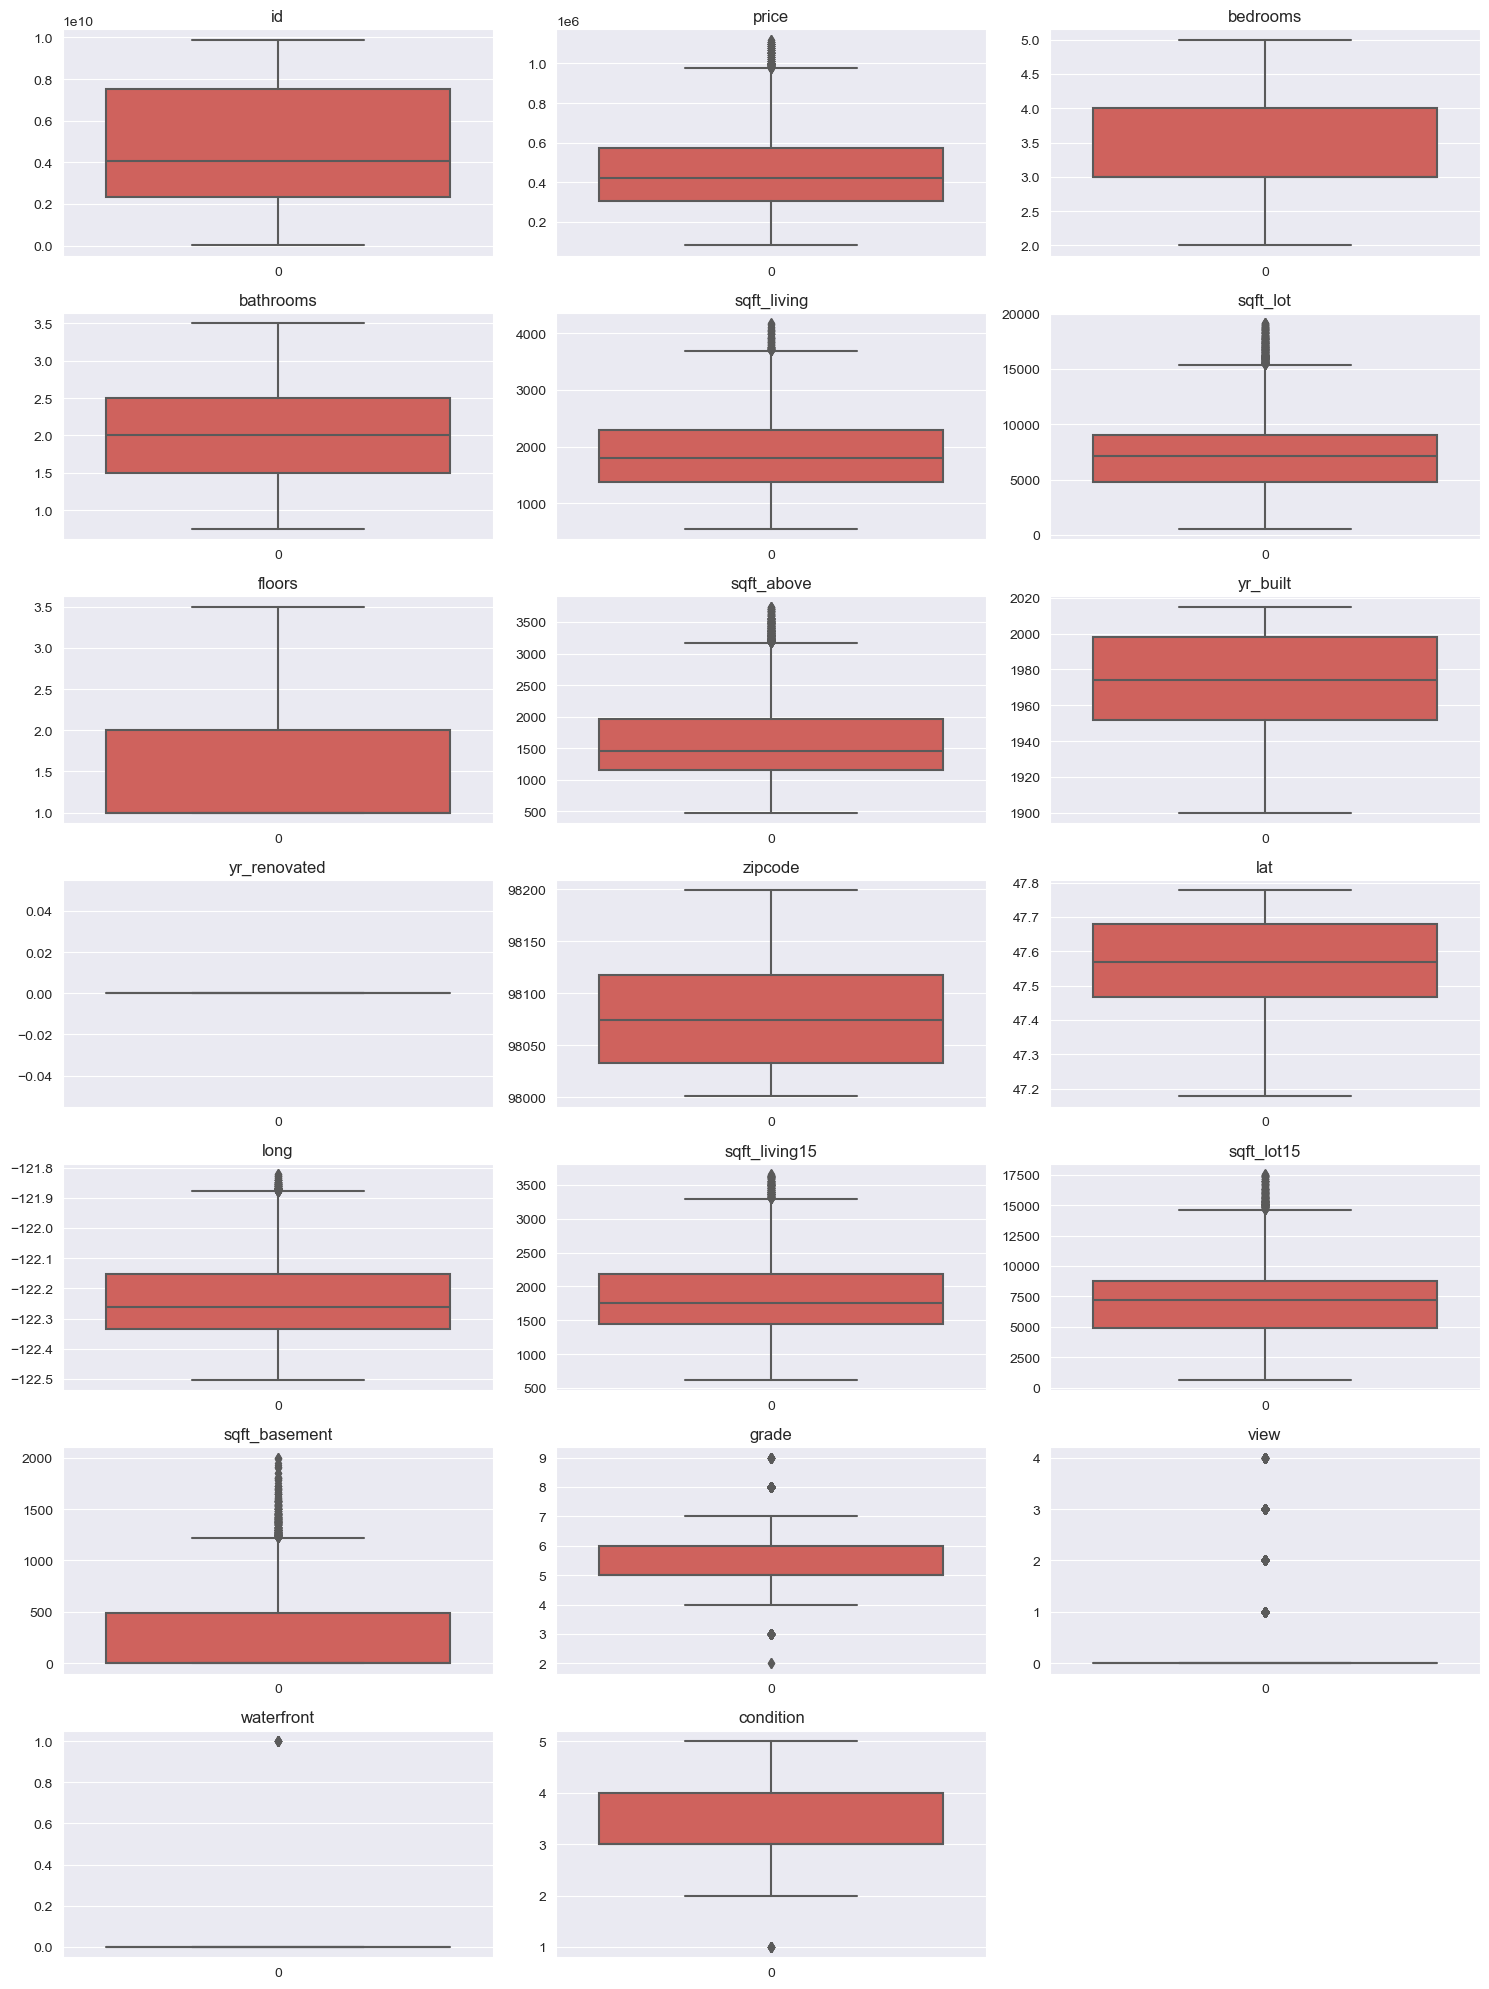

In [37]:
# Defining the number of rows and columns for subplots
num_rows = 7
num_cols = 3

# Creating the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

# Flattening the axes array for easy iteration
axes = axes.flatten()

# Iterating over each column
for i, column in enumerate(combined_df.columns):
    # Select the current axis
    ax = axes[i]

    # Creatomg a histogram with KDE
    sns.boxplot(combined_df[column], ax=ax)

    # Set the title and axis labels
    ax.set_title(column)

# Removing any unused subplots
if i+1 < num_rows * num_cols:
    for j in range(i+1, num_rows * num_cols):
        fig.delaxes(axes[j])

# Adjusting the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


**Boxplots show that the most data in the columns is not far away from the mean for the continuous numerical variables meaning data is not highly dispersed. For the distinct numerical variables or rather for the categorical variables which have been converted to numeric variables the numbers follow a hierachy from 1 to even 11 as an example in the 'grade' column hence they can fail to lie within a certain range from the mean.**

**The 'sqft_basement' column however has a lot of outliers this was because it was added after outliers had been removed lets see what happens when we remove outliers to the boxplot.**

In [38]:
# Removing outliers again since we have a new column sqft_basement which still has outliers
test_df = outliers(new_df)

# Combined this new dataframe without outliers to the categorical variables dataframe.
new_combined = test_df.join(categorical_df)

# Dropping the date column
new_combined.drop('date', axis=1, inplace=True)

# Seeing results
new_combined

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement,grade,view,waterfront,condition
0,7129300520,221900.0,3.0,1.00,1180.0,5650.0,1.0,1180.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0,0.0,5,0,0,3
3,2487200875,604000.0,4.0,3.00,1960.0,5000.0,1.0,1050.0,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0,910.0,5,0,0,5
4,1954400510,510000.0,3.0,2.00,1680.0,8080.0,1.0,1680.0,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0,0.0,6,0,0,3
6,1321400060,257500.0,3.0,2.25,1715.0,6819.0,2.0,1715.0,1995,0.0,98003,47.3097,-122.327,2238.0,6819.0,0.0,5,0,0,3
8,2414600126,229500.0,3.0,1.00,1780.0,7470.0,1.0,1050.0,1960,0.0,98146,47.5123,-122.337,1780.0,8113.0,730.0,5,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3.0,2.50,1530.0,1131.0,3.0,1530.0,2009,0.0,98103,47.6993,-122.346,1530.0,1509.0,0.0,6,0,0,3
21593,6600060120,400000.0,4.0,2.50,2310.0,5813.0,2.0,2310.0,2014,0.0,98146,47.5107,-122.362,1830.0,7200.0,0.0,6,0,0,3
21594,1523300141,402101.0,2.0,0.75,1020.0,1350.0,2.0,1020.0,2009,0.0,98144,47.5944,-122.299,1020.0,2007.0,0.0,5,0,0,3
21595,291310100,400000.0,3.0,2.50,1600.0,2388.0,2.0,1600.0,2004,0.0,98027,47.5345,-122.069,1410.0,1287.0,0.0,6,0,0,3


Now plotting boxplots of the new combined dataframe where 'sqft_basement' has been standardized.

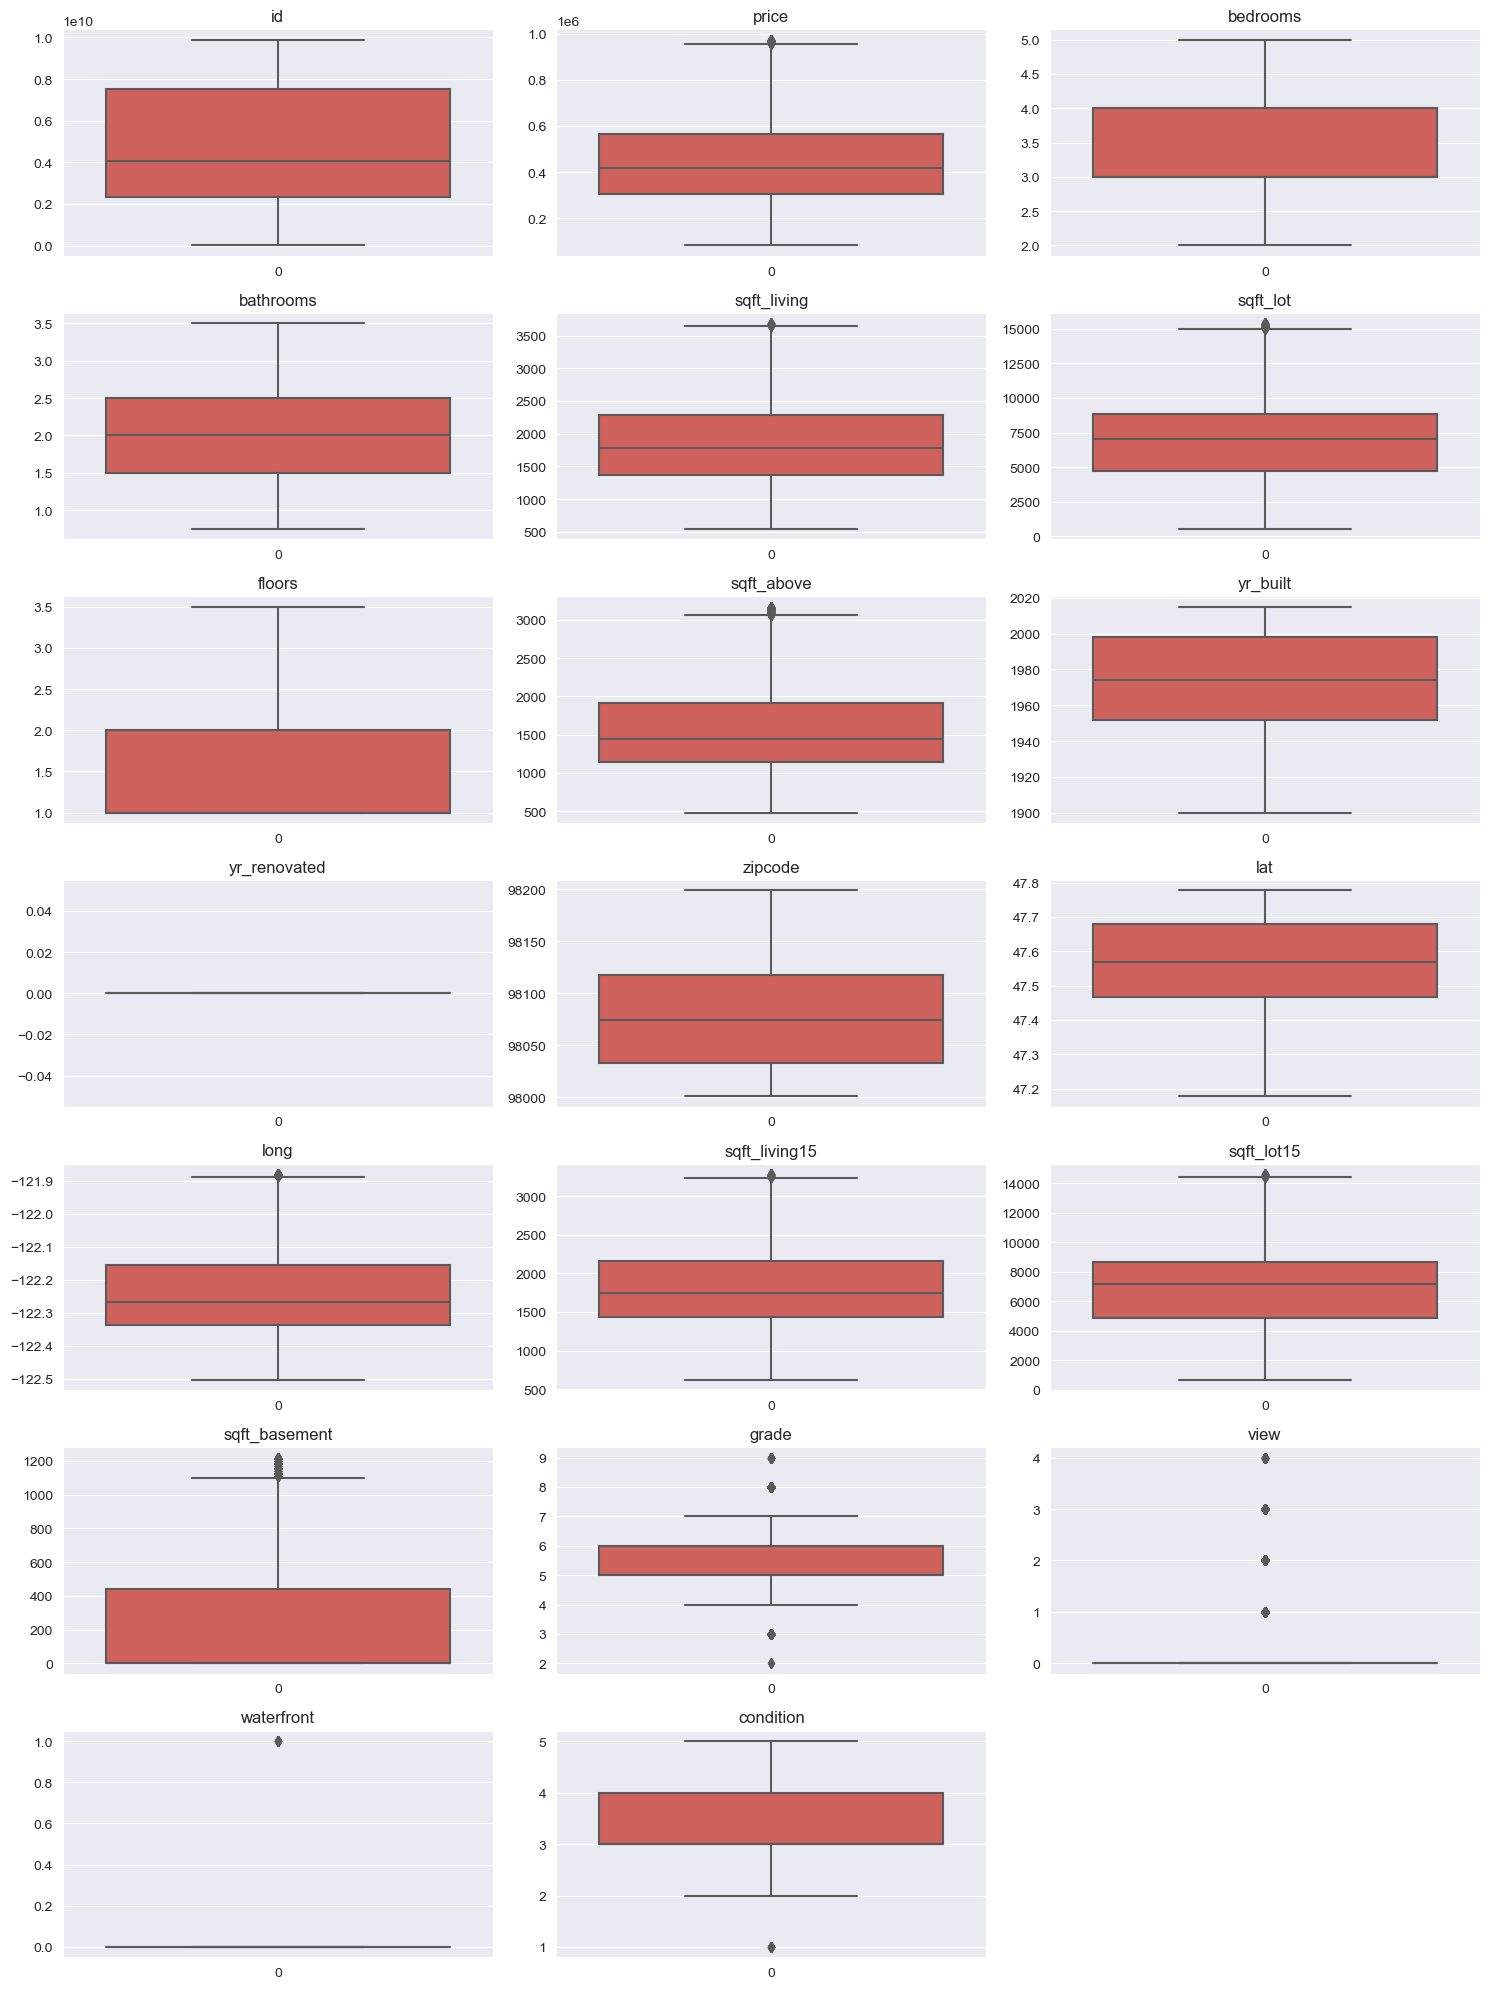

In [39]:
# Defining the number of rows and columns for subplots
num_rows = 7
num_cols = 3

# Creating the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

# Flattening the axes array for easy iteration
axes = axes.flatten()

# Iterating over each column
for i, column in enumerate(new_combined.columns):
    # Select the current axis
    ax = axes[i]

    # Creatomg a histogram with KDE
    sns.boxplot(new_combined[column], ax=ax)

    # Set the title and axis labels
    ax.set_title(column)

# Removing any unused subplots
if i+1 < num_rows * num_cols:
    for j in range(i+1, num_rows * num_cols):
        fig.delaxes(axes[j])

# Adjusting the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

**The number of outlier seems to have decreased lets see what happens when we try and plot the histogram for sqft_basement before and after removing of outliers.**

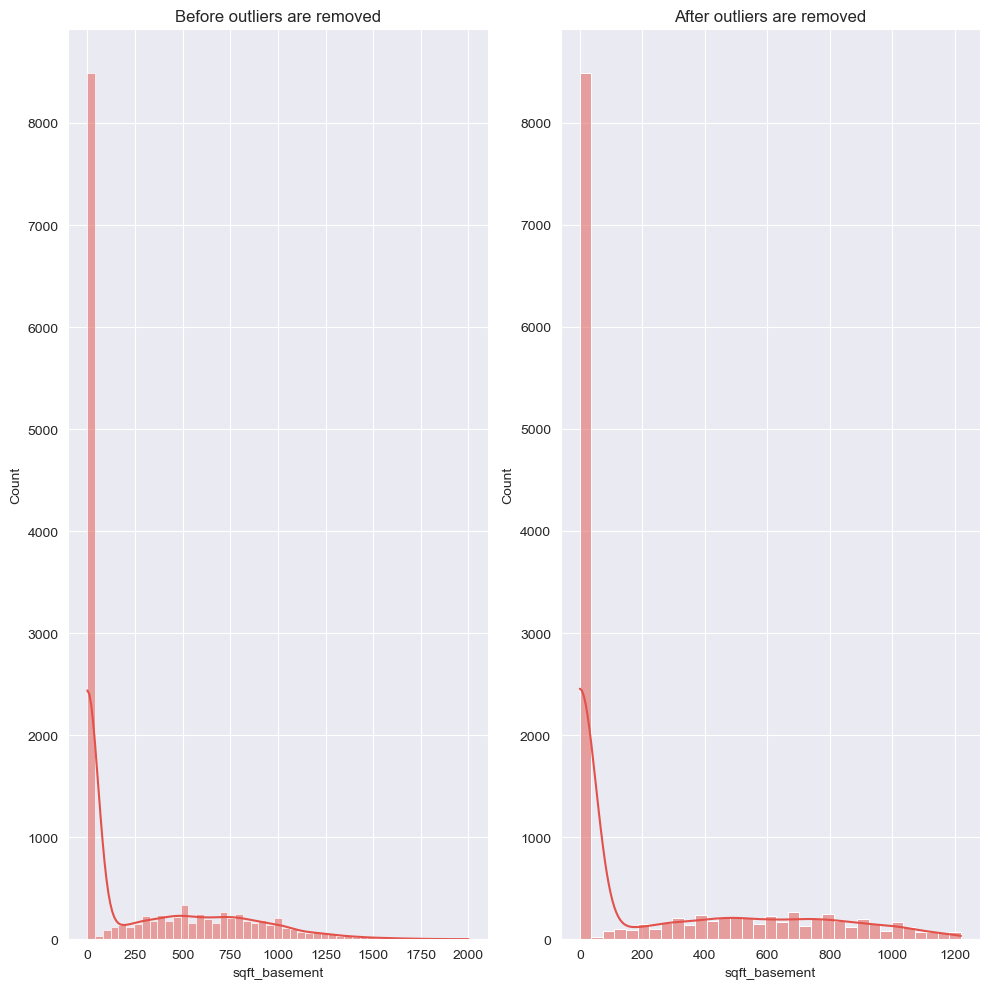

In [40]:
# Defining the number of columns
nrows = 2

fig, ax = plt.subplots(ncols=nrows, figsize=(10, 10))

# First plot before outliers are removed.
sns.histplot(combined_df['sqft_basement'], kde=True, ax=ax[0])
ax[0].set_title('Before outliers are removed')

# Second plot after outliers are removed.
sns.histplot(new_combined['sqft_basement'], kde=True, ax=ax[1])
ax[1].set_title('After outliers are removed')

plt.tight_layout()

**Removing outliers did not seem to have an effect on the distribution  of the sqft_basement column as the data is still heavily dispersed.**

#### With that we have concluded our univariate analysis where we have gotten a general sense of how the data is distributed the mean, max and min values how dispersed the data is and whether there are outliers in the dataset.

#### We have concluded that the continuous numeric variables of the dataset are mostly normal distributed and the data for these variables is not highly dispersed except for the 'sqft_basement' column. We have also learnt that all the data falls within 3 stds of the mean apart from a few categorical variables which have been converted to numeric.

### 6.2 BIVARIATE ANALYSIS

Here we will explore the relationship between independent variables and also the relationship between the independent variables and the dependent variable **price**.

Since we had already plotted a scatterplot of grade against saleprice as the column which had the highest correlation with price lets try plotting one for the second highest 'sqft_living' against 'price'

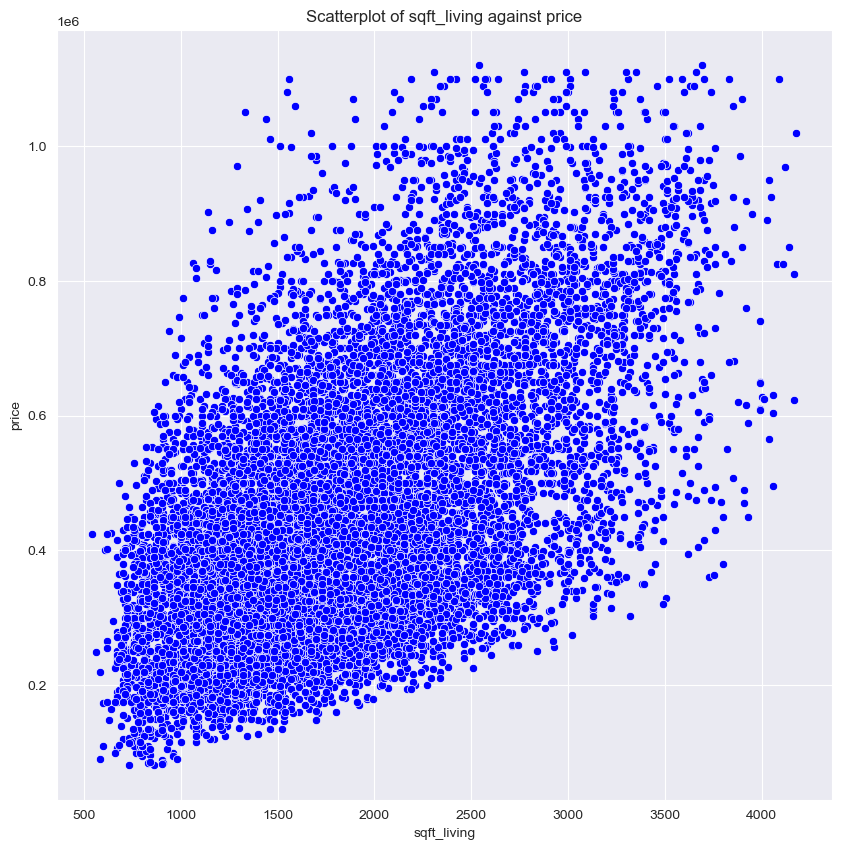

In [41]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=combined_df['sqft_living'], y=combined_df['price'], color='blue')
plt.title('Scatterplot of sqft_living against price');

**From this graph it is evident there is a high correlation between the 'sqft_living' column and the 'price' column there's also a positive covariance between the two variables.**

As a reminder we want to see how the independent variables correlate with the dependent variable price.

In [42]:
combined_df.corr()['price'].sort_values(ascending=False)

price            1.000000
grade            0.580068
sqft_living      0.565806
sqft_living15    0.510148
lat              0.465000
sqft_above       0.448941
bathrooms        0.377830
bedrooms         0.260439
view             0.239203
sqft_basement    0.236748
floors           0.232199
condition        0.070718
long             0.049897
waterfront       0.043475
id               0.038091
yr_built         0.012729
zipcode         -0.005081
sqft_lot        -0.024455
sqft_lot15      -0.030929
yr_renovated          NaN
Name: price, dtype: float64

Now we want to plot a heatmap to see how the variables are correlated with each other and with the dependent variable.

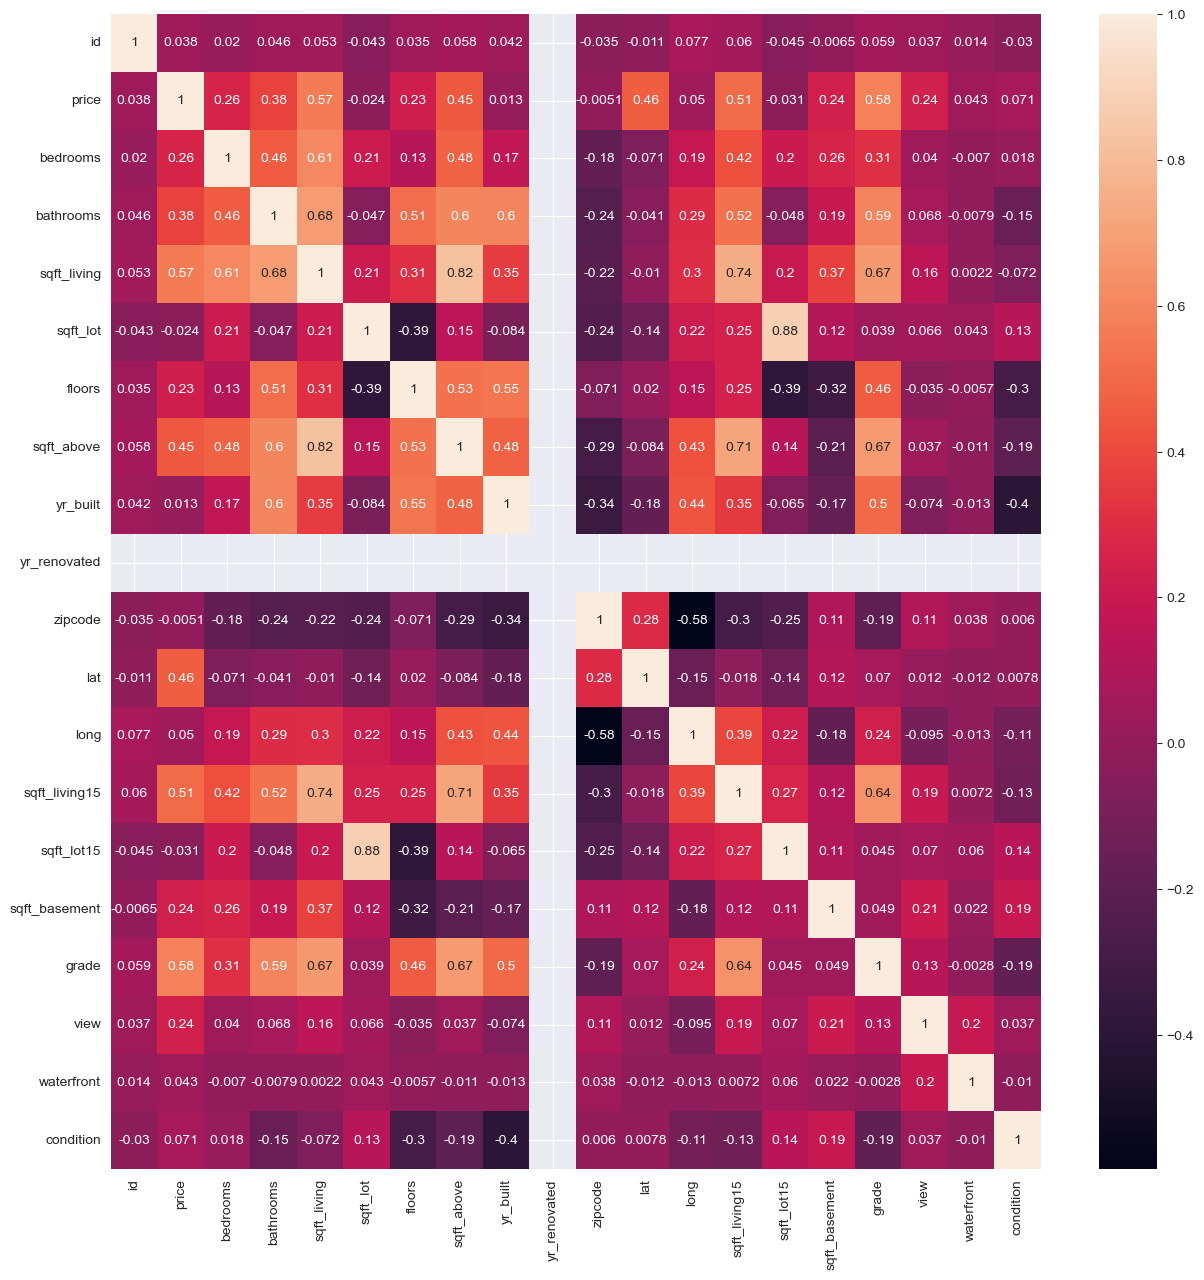

In [43]:
plt.figure(figsize=(15, 15))
sns.heatmap(combined_df.corr(), annot=True);

**From the heatmap we can see that several independent variables are correlated with each other and the independent variables shares a positive correlation with the dependent variables.**

We now want to do a scatterplot of the independent variables against the dependent variables to see how each of these independent variables corrrelate with the dependent variable.

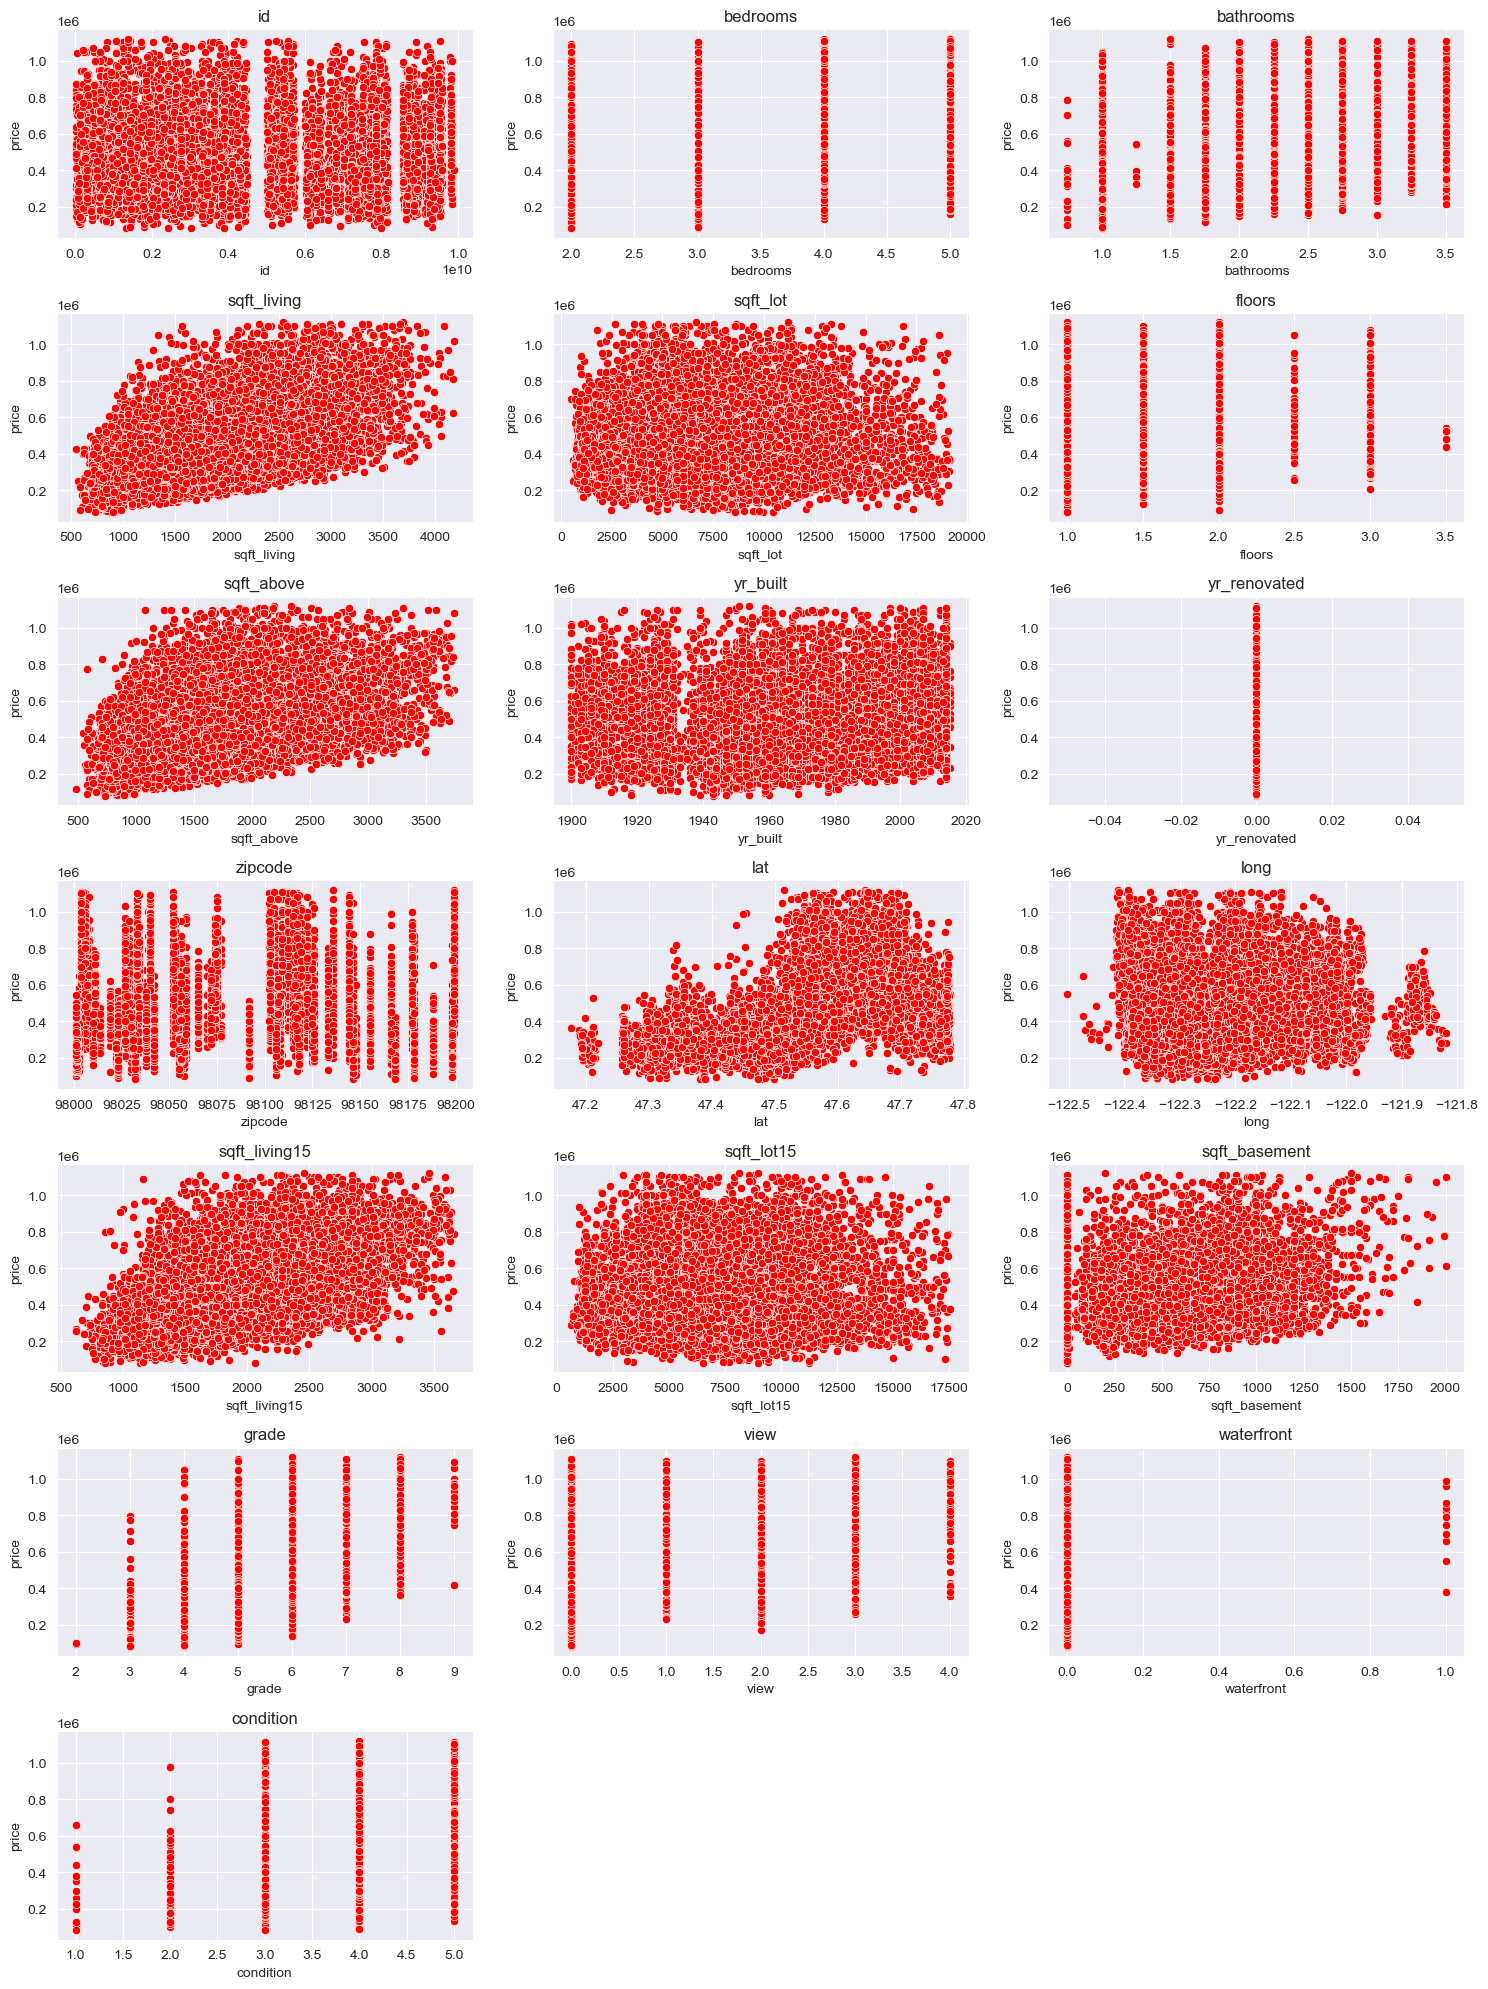

In [44]:
# First isolating the dependent and independent variable
x = combined_df.drop('price', axis=1)  # Independent variable
y = combined_df['price']  # Dependent variable

# Plotting
num_rows = 7
num_cols = 3

# Creating the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

# Flattening the axes array for easy iteration
axes = axes.flatten()

# Iterating over each column
for i, column in enumerate(x.columns):
    # Select the current axis
    ax = axes[i]

    # Creatomg a histogram with KDE
    sns.scatterplot(x=x[column], y=y, color='red', ax=ax)

    # Set the title and axis labels
    ax.set_title(column)

# Removing any unused subplots
if i+1 < num_rows * num_cols:
    for j in range(i+1, num_rows * num_cols):
        fig.delaxes(axes[j])

# Adjusting the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


**This is interesting the longitude, latitude, id, zipcode, yr_built and yr_renovated variables seem to have little to no correlation with the dependent variable price.**

**The categorical variables converted to numeric variables seem to follow similar patterns of distinct groups of numbers seperated by spaces. Hence once converted they can be said to be distinct numeric variables.**

**The sqft_living, sqft_living15, bedrooms, floors and the categorical variables turned numeric variables however seem to have a strong correlation with the price variable.**

Finally we want to see for each categorical variable how an increase affects the mean saleprice of the house.

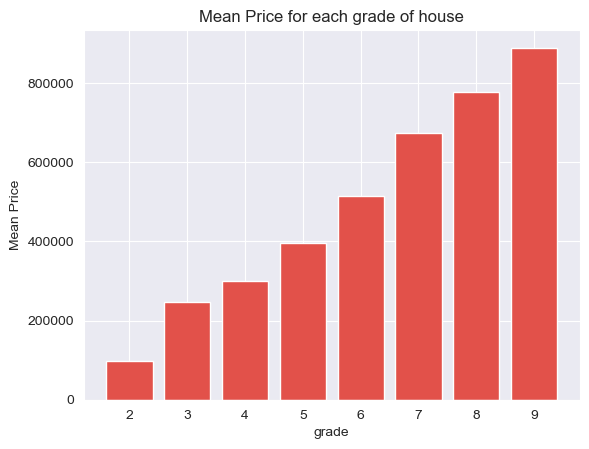

In [45]:
grade_7 = combined_df[combined_df['grade'] == 5]
grade_7['price'].mean()

# Function for plotting mean values for each distinct value in the categorical variables
def categorical_plotter(df, k, type):
    mean_dict = {}
    for i in range(1, k):
        grade = df[df[type] == i]
        mean = grade['price'].mean()
        mean_dict[i] = mean

    plt.bar(x=mean_dict.keys(), height=mean_dict.values());
    plt.title(f'Mean Price for each {type} of house')
    plt.xlabel(type)
    plt.ylabel('Mean Price');
    
    plt.show()


# Checking if the function works
categorical_plotter(combined_df, 10, 'grade')

**As the grade of the house improves so does the average selling price.**

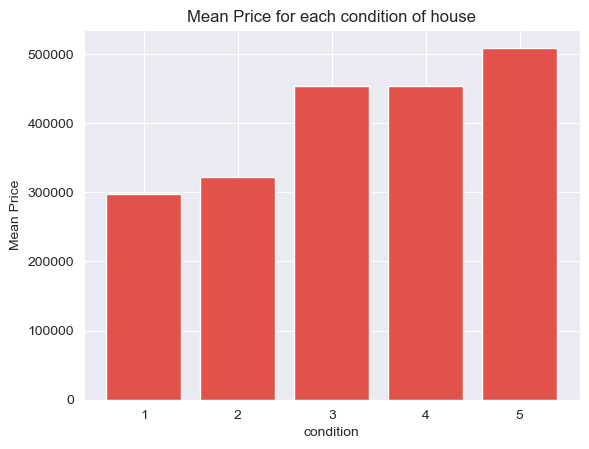

In [46]:
categorical_plotter(combined_df, 6, 'condition')

**As the condition of the house improves so does the average selling price.**

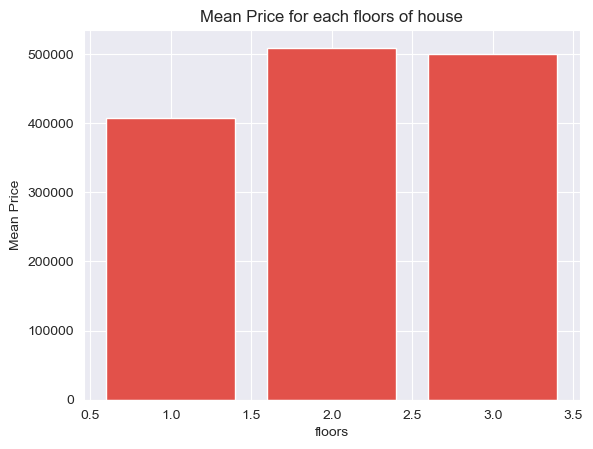

In [47]:
categorical_plotter(combined_df, 4, 'floors')

**As the number of floors increases so does the average selling price.**

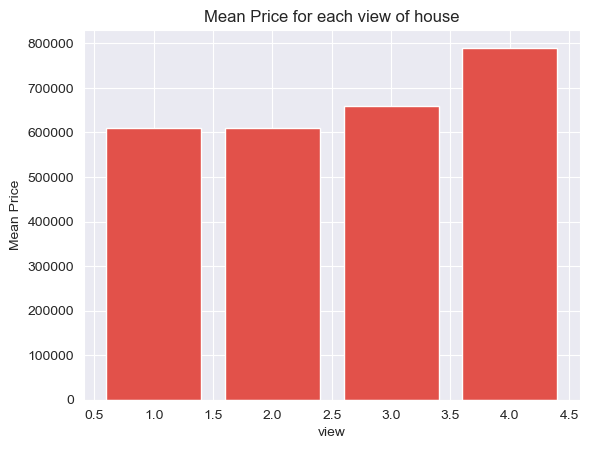

In [48]:
categorical_plotter(combined_df, 5, 'view')

**As the quality of view increases so does the average selling price**

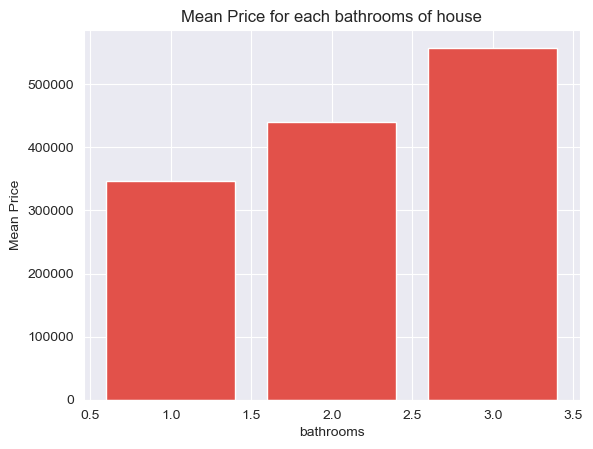

In [49]:
categorical_plotter(combined_df, 4, 'bathrooms')

**As the number of bathrooms increases so does the average price**

The general pattern is for distinct numerical variables and categorical variables converted to numeric variables is as the number increases so does the average selling price.

#### With this we have understood the relationship between the numeric variables and the dependent variables, the relationship between independent variables and the relationship between distinct numeric variables and the dependent variables.

#### Bivariate analysis is therefore complete and we can move on to modelling.

In [51]:
! pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install

[I 09:31:07 InstallContribNbextensionsApp] jupyter contrib nbextension install 
[I 09:31:07 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 09:31:07 InstallContribNbextensionsApp] Installing C:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\addbefore -> addbefore
[I 09:31:07 InstallContribNbextensionsApp] Making directory: C:\ProgramData\jupyter\nbextensions\addbefore\
[I 09:31:07 InstallContribNbextensionsApp] Copying: C:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\addbefore\addbefore.yaml -> C:\ProgramData\jupyter\nbextensions\addbefore\addbefore.yaml
[I 09:31:07 InstallContribNbextensionsApp] Copying: C:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\addbefore\icon.png -> C:\ProgramData\jupyter\nbextensions\addbefore\icon.png
[I 09:31:07 InstallContribNbextensionsApp


     ---------------------------------------- 23.5/23.5 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 466.9/466.9 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 3.8/3.8 MB 1.6 MB/s eta 0:00:00
  Created wheel for jupyter_contrib_nbextensions: filename=jupyter_contrib_nbextensions-0.7.0-py2.py3-none-any.whl size=23428802 sha256=569e0dab67e0aa6e2cf2517c1a6549d921e646ef6cef1e33a6aebb445de7bb02
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\ea\cc\7d\99ef154f984726b1201c0f72cfe9c9d7c5132c1a2ae4d8677f
  Created wheel for jupyter_contrib_core: filename=jupyter_contrib_core-0.4.2-py2.py3-none-any.whl size=17498 sha256=b1a97bfaec240726fbf9a5ae6296fee1aa2737ad19ca9bd0d6860e75a161681b
  Stored in directory: c:\users\user\appdata\l